## Data Preprocessing

Preprocessing data with respect to required image size or whether `augmentation` is needed during training will save time for GPU to wait for CPU to finish a bunch of preprocessing tasks that could be done ahead of time. I have written two helper functions (`pickle_sets` and `generate_metadata`) and 3 additional classes (`ENindoor67Preprocessor`, `ENindoor67Processed`, `ENindoor67Datasets`) to optimize the above task and data loading during training.

---

To use these functions and classes:

`from utils.data import pickle_sets, compile_metadata` [[source]](../source/utils/data.py)

`from dataset.ENindoo67_preprocessor import ENindoor67Preprocessor` [[source]](../source/dataset/ENindoor67_preprocessor.py)

`from dataset.ENindoor67 import ENdindoor67Preprocessed, ENindoor67Datasets` [[source]](../source/dataset/ENindoor67.py)

***Note: To train the Benchmark, you need to preprocess & upload `efficientnet-b0` (3 x 224 x 224); for the final model of this project, preprocess & upload `efficientnet-b3` (3 x 300 x 300)***

In [1]:
import sys
sys.path.append('../source')

efficientnet = "efficientnet-b0"  # change this to work with different efficientNets
subsets = ["train", "val", "test"]  # change this to work with `train`, `val`, `test`
visual_set = "train" # change this to visualize any of `train` , `val` and `test`

In [2]:
import boto3
from dataset.ENindoor67 import ENindoor67
from utils.data import pickle_sets
from sagemaker.session import Session

session = Session()  # sagemaker session
bucket = session.default_bucket()  # bucket name

s3_bucket = boto3.resource('s3').Bucket(bucket)  # S3 Bucket Oject for uploading
s3_csv = '../data/mit_indoor_67.csv'  # csv file containing s3 paths


Pickle dataset for specific EfficientNet, this should take less than 10 minutes

*(Note: for train set, we will prepare both original and augmented datasets)*

In [ ]:
# Pickle Sets

# parameters for train, val, test splitting
split_parameters = {
                     "train_size" : 0.8,  # train set size
                     "val_size" : 0.2,  # val set size
                     "shuffle" : True,  # shuffle or not
                     "random_state" : 1,  # random seed
                     "stratify" : True  # stratified splitting or not
                     }

augment = True  # if `True`, perform data augmentation
rounds = 2  # number of extra augmented datasets
parts =  (int(efficientnet[-1]) + 4) * 2  # scale partition size to avoid MemoryError on ml.t2.medium

# instantiate dataset class with uploaded s3 raw images and pickle the dataset
dataset_df = pickle_sets(target_dir='../data/mit_indoor_67/processed',
                                           data_file=s3_csv,
                                           bucket=s3_bucket,
                                           sets=subsets,
                                           augment=augment,
                                           efficientnet=efficientnet,
                                           parts=parts,
                                           split_parameters=split_parameters,
                                           rounds=rounds)  # creates extra augmented train sets

print("train set size: {}, val set size: {}, test set size: {}".format(dataset_df.groupby('Set').size()['train'] * (rounds+1) if augment else dataset_df.groupby('Set').size()['train'], dataset_df.groupby('Set').size()['val'], dataset_df.groupby('Set').size()['test']))

Preprocessing train, val, test set(s) for efficientnet-b0...
subset train length: 9996
Preprocessing train set data...
Composer configuration: Composer(mode=raw, efficientnet=efficientnet-b0, augment=True, transformer=<dataset.ENindoor67.PowerPIL object at 0x7f4454745828>)
train will be augmented for 2 rounds.
Processed 200 / 9996 image.
Processed 400 / 9996 image.
Processed 600 / 9996 image.
Processed 800 / 9996 image.
Processed 1000 / 9996 image.
Processed 1200 / 9996 image.
Pickled part 1 of train set data to ../data/mit_indoor_67/processed/train/efficientnet_b0/indoor67_augmented_train_01.pkl.
Processed 1400 / 9996 image.
Processed 1600 / 9996 image.
Processed 1800 / 9996 image.
Processed 2000 / 9996 image.
Processed 2200 / 9996 image.
Processed 2400 / 9996 image.
Pickled part 2 of train set data to ../data/mit_indoor_67/processed/train/efficientnet_b0/indoor67_augmented_train_02.pkl.
Processed 2600 / 9996 image.
Processed 2800 / 9996 image.
Processed 3000 / 9996 image.
Processed 3

Note that preprocessing and pickling are both done and wrapped in `pickle_sets` method [[source](../source/utils/data.py)].

---
Let's check if everything is done as expected.

*Note: on a ml.t2.medium we only visualize a fraction of the `train` set since the large dataset will cause `MemoryError`*

In [5]:
# Check if the train set is properly processed, dumped and loaded
import os
from dataset.ENindoor67 import ENindoor67Preprocessed, ENindoor67Datasets
from glob import glob

# instantiate dataset with local pickles pointing to local directory
# Note you may need to restart the kernel on a ml.t2.medium to avoid MemoryError / dead kernel
preprocessed_dir = '../data/mit_indoor_67/processed/{}/{}'.format(visual_set, efficientnet.replace("-", "_"))
preprocessed_files = glob(os.path.join(preprocessed_dir, "*"))

data length: 5004


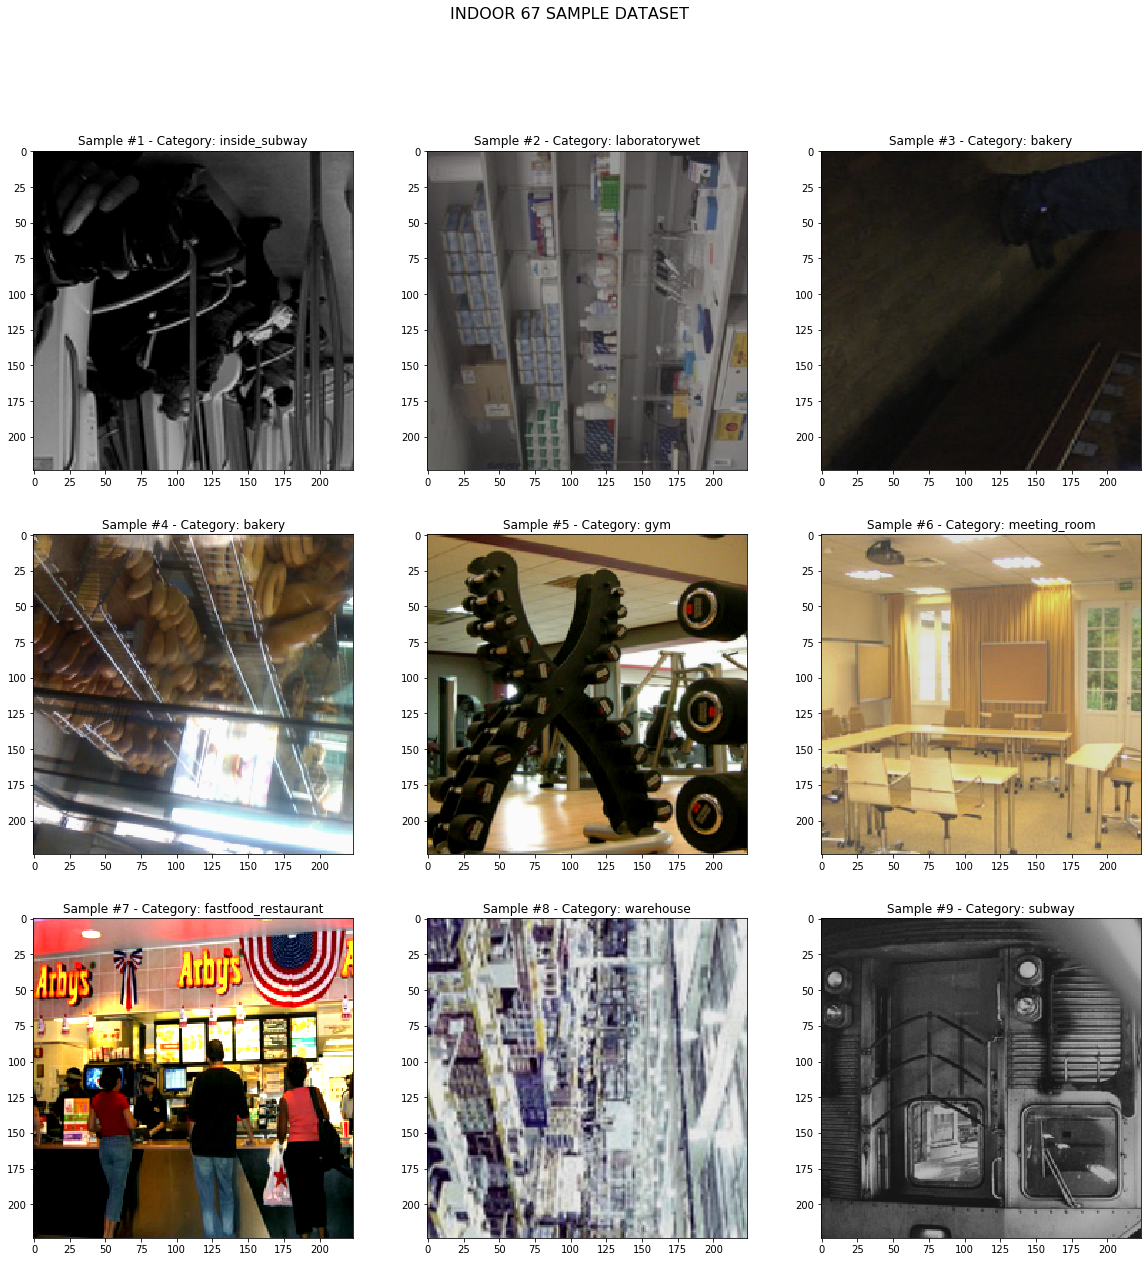

In [4]:
# trim short to avoid MemoryError
augmented_datasets = [ENindoor67Preprocessed(file) for file in preprocessed_files[:2] if 'augmented' in file] 
augmented_datasets = ENindoor67Datasets(augmented_datasets)
print(f"data length: {len(augmented_datasets)}")
augmented_datasets.datasets[0].show_sample()  # visualize subset

data length: 9996


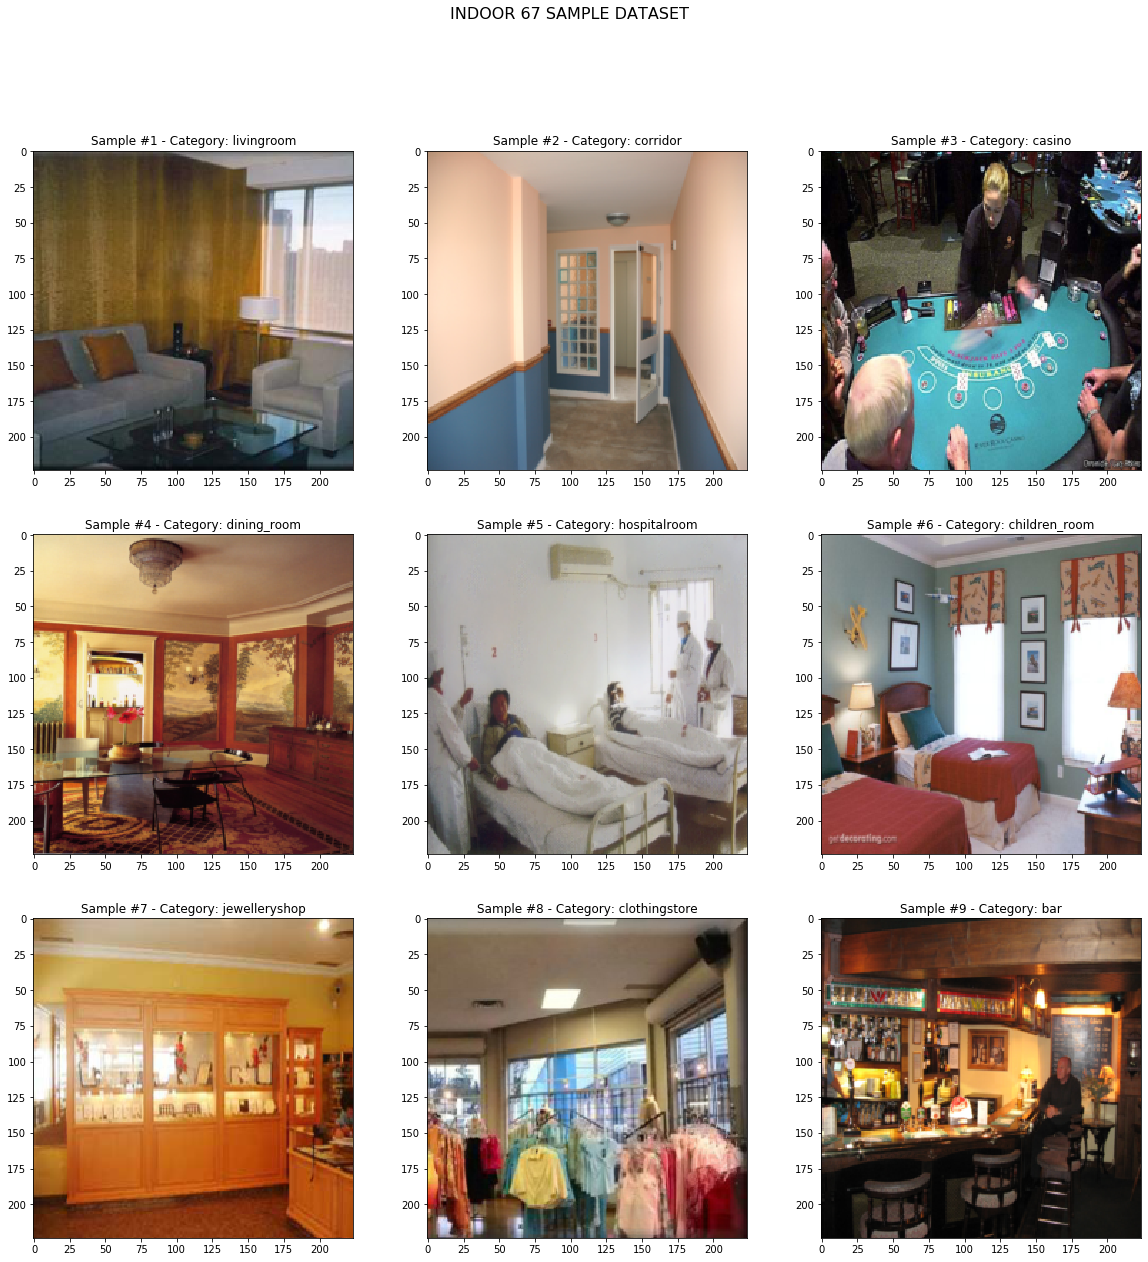

In [4]:
# Note: restart the kernel to load the original images to avoid Memory Error
original_files = [ENindoor67Preprocessed(file) for file in preprocessed_files if 'original' in file]
original_datasets = ENindoor67Datasets(original_files)
print(f"data length: {len(original_datasets)}")
original_datasets.datasets[0].show_sample()  # Show examples to check

The train set seems to be properly augmented/keep as original, resized and loaded.

Let's quickly check the `val` and `test` sets:

VALIDATION SET

data length: 2500


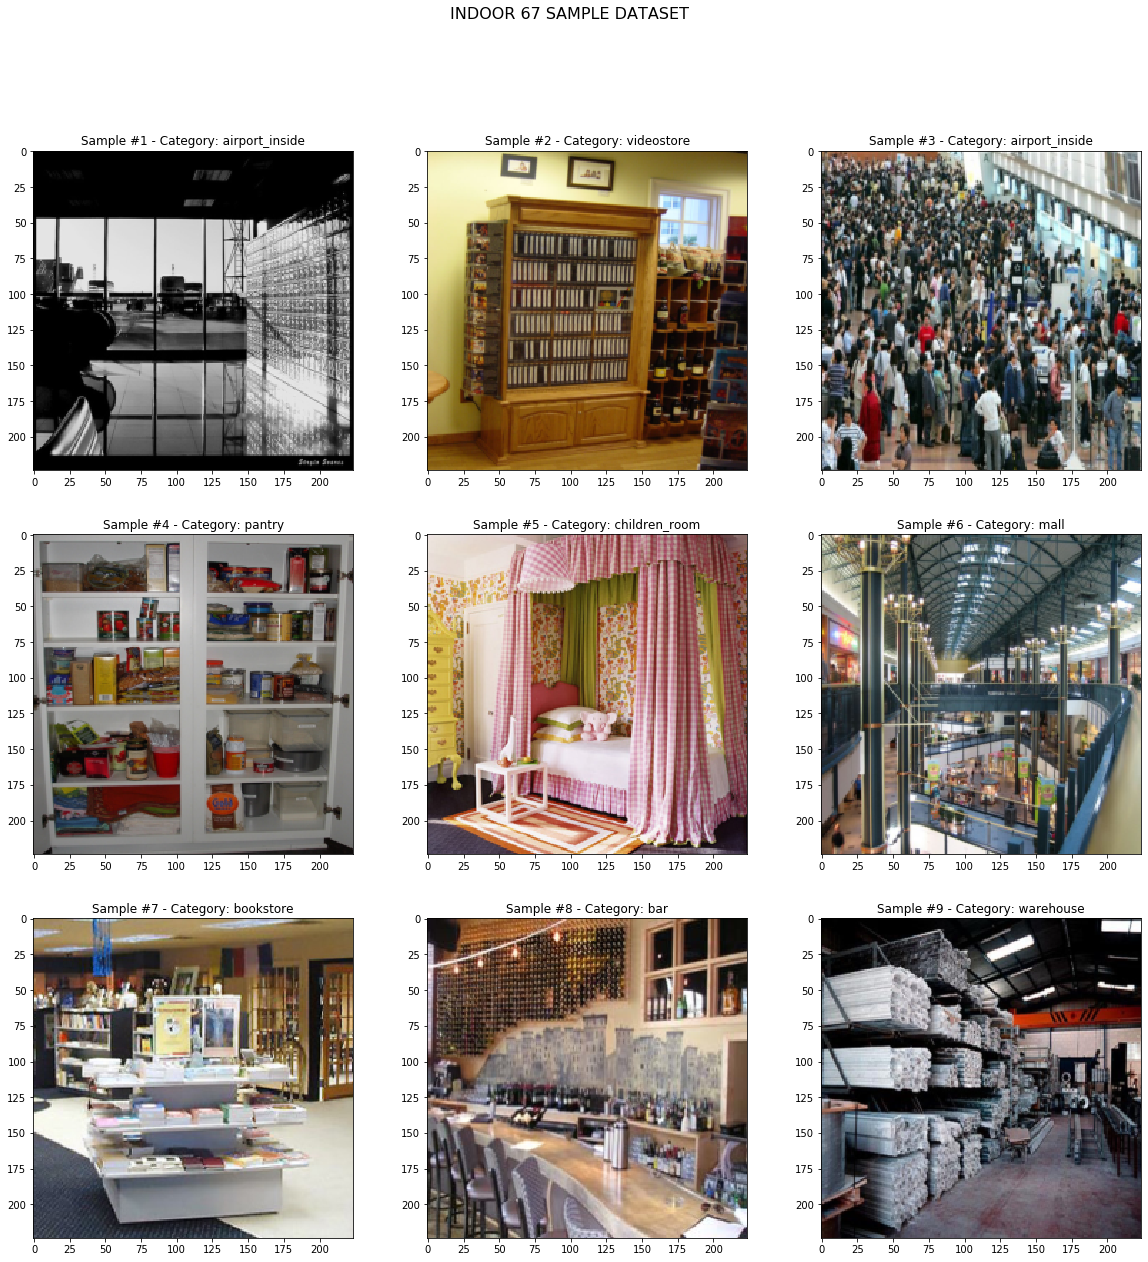

In [4]:
import os
from dataset.ENindoor67 import ENindoor67Preprocessed, ENindoor67Datasets
from glob import glob

visual_set = 'val'
preprocessed_dir = '../data/mit_indoor_67/processed/{}/{}'.format(visual_set, efficientnet.replace("-", "_"))
preprocessed_files = glob(os.path.join(preprocessed_dir, "*"))
val_datasets = [ENindoor67Preprocessed(file) for file in preprocessed_files]
val_dataset = ENindoor67Datasets(val_datasets)
# assert len(val_datasets) == len(dataset_df.val), "length of preprocessed data does not agree with original dataset length"
print(f"data length: {len(val_dataset)}")
val_dataset.datasets[0].show_sample()

TEST SET

data length: 3124


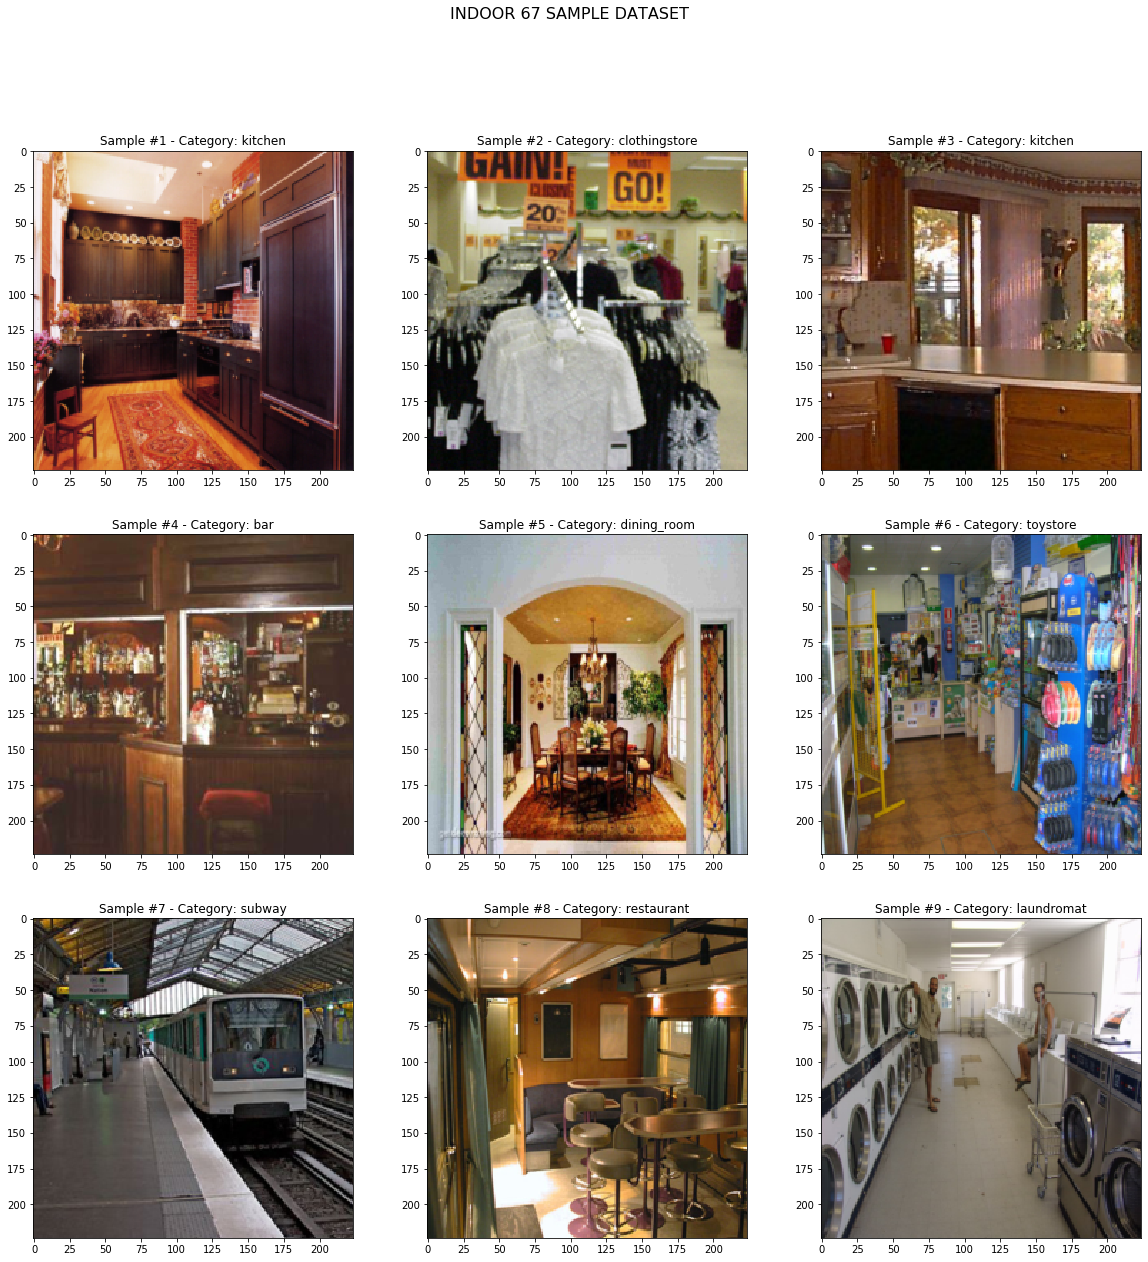

In [5]:
visual_set = 'test'
preprocessed_dir = '../data/mit_indoor_67/processed/{}/{}'.format(visual_set, efficientnet.replace("-", "_"))
preprocessed_file = os.path.join(preprocessed_dir, "indoor67_test.pkl")
test_dataset = ENindoor67Preprocessed(preprocessed_file)
print(f"data length: {len(test_dataset)}")
# assert len(test_dataset) == len(dataset_df.test), "length of preprocessed data does not agree with original dataset length"
test_dataset.show_sample()

---
## Upload to S3

To channel from S3 later on during training, we will upload the dataset to S3.

***MemoryError Alert: if you are running this kernel on a ml.t2.medium and have run the visualization above, make sure you restart the kernel, run the first two cells before running the cell below***

In [3]:
# Upload pickles to S3
from utils.s3 import s3_upload
from utils.data import compile_metadata
from dataset.ENindoor67 import Composer
from glob import glob
import os

# Define directory variables
root_dir = "../data/mit_indoor_67/processed/"
s3_prefix = "mit_indoor_67/processed"
metadata_dir = "../data/mit_indoor_67/metadata"
remove = True  # remove local directories after upload if `True`

# Iterate throught the sets: upload to S3, generate metadata, and remove local dir
for subset in subsets:
    s3_locations = []
    preprocessed_key = os.path.join(subset, efficientnet.replace('-', '_'))
    pickle_path = os.path.join(root_dir, preprocessed_key)
    
    if subset == 'test':
        test_pickle = "indoor67_test.pkl"
        pickle = os.path.join(pickle_path, test_pickle)
        s3_upload(pickle, session, bucket, prefix=s3_prefix, preprocessed_key=preprocessed_key, verbose=False)
        s3_dir = os.path.join('s3://', bucket, s3_prefix, preprocessed_key, test_pickle)
    
    else:
        pickles = glob(os.path.join(pickle_path, "*")) 
        for pickle in pickles:    
            # Upload to S3
            s3_upload(pickle, session, bucket, prefix=s3_prefix, preprocessed_key=preprocessed_key, verbose=False)

        s3_dir = os.path.join('s3://', bucket, s3_prefix, preprocessed_key)
        print(f"Uploaded {len(pickles)} pickle files to {s3_dir}")

    # compile Metadata
    compile_metadata(metadata_dir, subset, s3_dir, efficientnet)
    
    if remove:
        
        # Remove local directories and files
        !rm -rf $pickle_path/*
        !rmdir $pickle_path/
        print(f"local directory {pickle_path} removed.")
        print()
    
    print(f"s3 directory: {s3_dir}")
    !aws s3 ls $s3_dir/  # check if files are properly uploaded

Uploaded 18 pickle files to s3://sagemaker-us-east-2-194071253362/mit_indoor_67/processed/train/efficientnet_b0
Pickle metadata:
    {'train': 's3://sagemaker-us-east-2-194071253362/mit_indoor_67/processed/train/efficientnet_b0'}
local directory ../data/mit_indoor_67/processed/train/efficientnet_b0 removed.

s3 directory: s3://sagemaker-us-east-2-194071253362/mit_indoor_67/processed/train/efficientnet_b0
2020-12-06 23:10:39  376229199 indoor67_augmented_train_01.pkl
2020-12-06 23:10:30  376229199 indoor67_augmented_train_02.pkl
2020-12-06 23:11:29  376229199 indoor67_augmented_train_03.pkl
2020-12-06 23:11:08  376229199 indoor67_augmented_train_04.pkl
2020-12-06 23:11:23  376229199 indoor67_augmented_train_05.pkl
2020-12-06 23:10:54  376229199 indoor67_augmented_train_06.pkl
2020-12-06 23:11:34  376229199 indoor67_augmented_train_07.pkl
2020-12-06 23:10:48  376229199 indoor67_augmented_train_08.pkl
2020-12-06 23:10:45    1204886 indoor67_augmented_train_09.pkl
2020-12-06 23:10:35  1922

## Visualize Train Images from S3

Now let's retrieve the data from S3 and visualize the respective train images.

See how well the extra 2 augmented images using our `Composer` look.

*Note: a helper function `show_train_images` has been written*

Let's have a look at the category `kitchen`

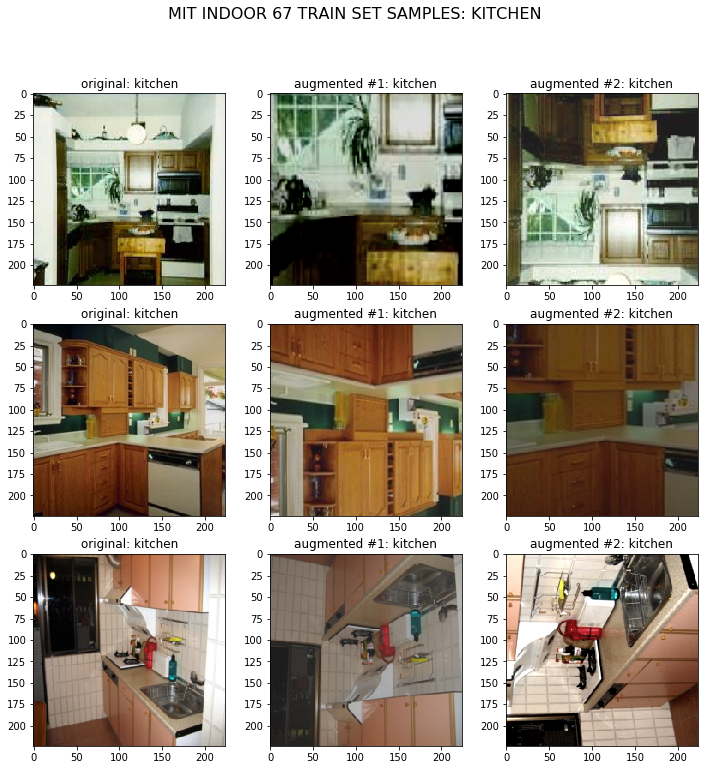

In [11]:
import s3fs
import pickle
from utils.data import show_train_images
metadata_file = os.path.join(metadata_dir, efficientnet.replace("-", "_") + ".pkl")
metadata = pickle.load(open(metadata_file, 'rb'))

fs = s3fs.S3FileSystem()
# change to a valid MIT Indoor 67 category to visualize
show_train_images(filesystem=fs, data_dir=metadata['train'], bucket=s3_bucket, category='kitchen')

Then let's see some random categories:

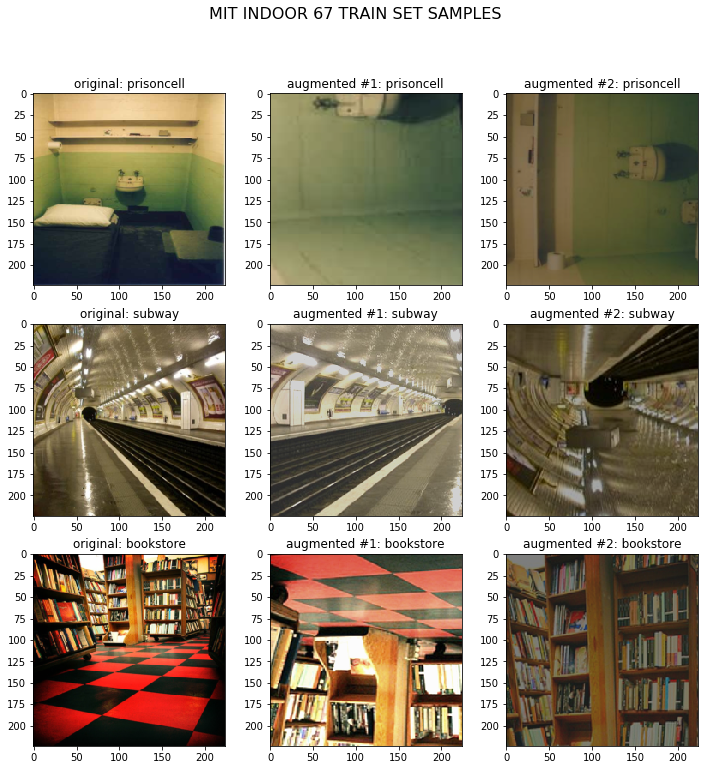

In [13]:
# Show random category
show_train_images(filesystem=fs, data_dir=metadata['train'], bucket=s3_bucket)

It seems that the train images were preprocessed as expected. We can now move onto training the models:

[Benchmark Model (ResNeXt101_32x16d_WSL)](./ResNeXt101.ipynb)

[EfficientNet Base Model](./EfficientNets-Base.ipynb)

[EfficientNet Hyperparameter and Architecture Tuning by Bayesian Search](./EfficientNets-HPO.ipynb)

---
Before moving on, make sure we also remove the original raw images to save space.

In [14]:
# Clean up local raw image directory
raw_path = 'data/mit_indoor_67/raw/'
!rm -rf $raw_path/*
!rmdir $raw_path

rmdir: failed to remove ‘data/mit_indoor_67/raw/’: No such file or directory
